In [1]:
!pip install pastas -q

     |████████████████████████████████| 112kB 4.0MB/s 


In [2]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.show_versions()

Python version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Numpy version: 1.19.5
Scipy version: 1.4.1
Pandas version: 1.1.5
Pastas version: 0.17.1
Matplotlib version: 3.2.2


In [3]:
head = pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/examples/notebooks/data_notebook_5/head_wellex.csv",
                   index_col="Date", parse_dates=True, squeeze=True)
rain =  pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/examples/notebooks/data_notebook_5/prec_wellex.csv",
                    index_col="Date", parse_dates=True)
evap =  pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/examples/notebooks/data_notebook_5/evap_wellex.csv",
                    index_col="Date", parse_dates=True)
well =  pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/examples/notebooks/data_notebook_5/well_wellex.csv",
                    index_col="Date", parse_dates=True)

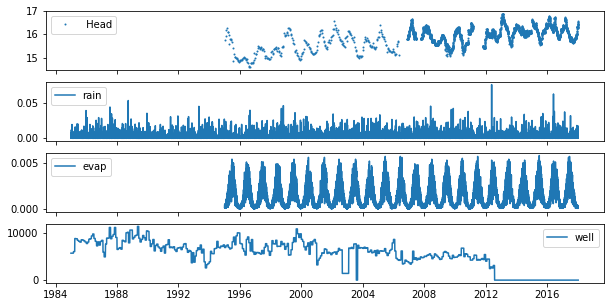

In [4]:
# Make a plot of all the time series
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10,5));
ax[0].plot(head, label=head.name, linestyle=" ", marker=".", markersize=2)
ax[0].legend()
ax[1].plot(rain, label="rain")
ax[1].legend()
ax[2].plot(evap, label="evap")
ax[2].legend()
ax[3].plot(well, label="well")
ax[3].legend()

INFO: Cannot determine frequency of series  Head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series  Prec: freq=D
INFO: Inferred frequency for time series  Evap: freq=D
INFO: Time Series  Evap was extended to 1985-01-16 00:00:00 with the mean value of the time series.


Fit report groundwater              Fit Statistics
nfev    27                     EVP           51.75
nobs    3869                   R2             0.12
noise   1                      RMSE           0.33
tmin    1995-01-14 00:00:00    AIC         7179.09
tmax    2018-01-12 00:00:00    BIC         7210.40
freq    D                      Obj            1.95
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (5 optimized)
                optimal   stderr     initial  vary
recharge_A   843.812285  ±62.70%  203.104730  True
recharge_a   545.886772  ±62.39%   10.000000  True
recharge_f    -1.938694  ±11.01%   -1.000000  True
constant_d    16.516778   ±3.24%   15.975755  True
noise_alpha  281.473334  ±27.22%    1.000000  True


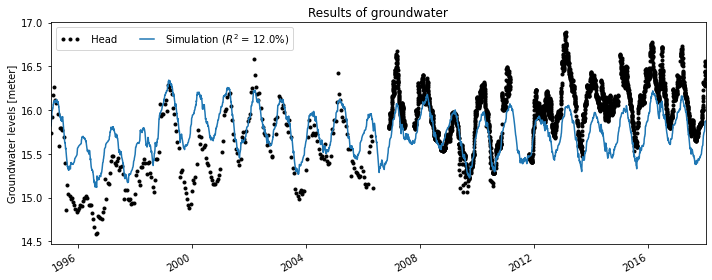

In [5]:
model = ps.Model(head, name="groundwater")

# Add the stres model for the net recharge
rechargeModel = ps.RechargeModel(rain, evap, name="recharge",
                      rfunc=ps.Exponential, recharge=ps.rch.Linear())
model.add_stressmodel(rechargeModel)
model.solve(noise=True)
model.plot(figsize=(10,4))

# Let's store the simulated values to compare later
simulation = model.simulate()
residual = model.residuals()
noise = model.noise()

INFO: Inferred frequency for time series  Well: freq=D


Fit report groundwater                 Fit Statistics
nfev    23                     EVP           74.93
nobs    3869                   R2             0.74
noise   1                      RMSE           0.18
tmin    1995-01-14 00:00:00    AIC         6897.05
tmax    2018-01-12 00:00:00    BIC         6947.13
freq    D                      Obj            1.93
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (8 optimized)
                   optimal   stderr     initial  vary
recharge_A      724.084893  ±27.90%  203.104730  True
recharge_a      451.517417  ±27.99%   10.000000  True
recharge_f       -1.862321   ±9.75%   -1.000000  True
pumping well_A -102.783549   ±9.58% -338.167845  True
pumping well_n    1.288019  ±33.96%    1.000000  True
pumping well_a   75.647762  ±57.72%   10.000000  True
constant_d       16.774762   ±1.54%   15.975755  True
noise_alpha      82.886865  ±15.38%    1.000000  True


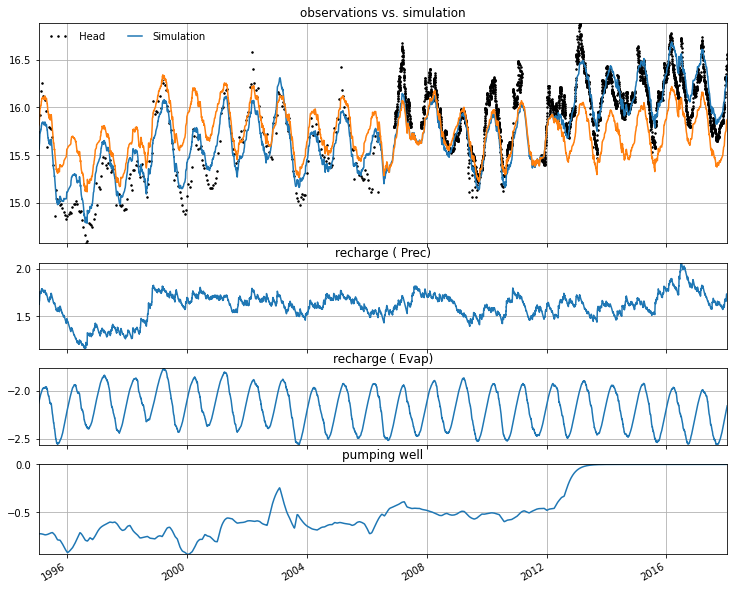

In [6]:
# Add the stress model for the pumping well
stressModel = ps.StressModel(well/1e6, rfunc=ps.Gamma, name="pumping well", settings="well", up=False)
model.add_stressmodel(stressModel)

# Solve the model and make a plot
model.solve()
axes = model.plots.decomposition(figsize=(10,8))
axes[0].plot(simulation) # Add the previously simulated values to the plot


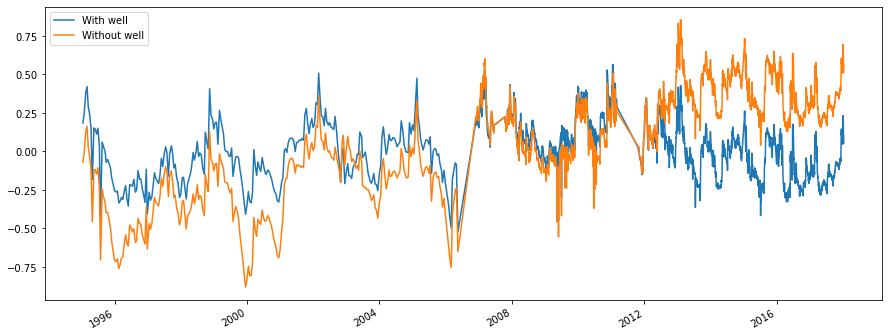

In [7]:
#Analyze the residuals
model.residuals().plot(figsize=(15,6))
residual.plot()
plt.legend(["With well", "Without well"])